<a href="https://colab.research.google.com/github/GarettGazay/ai_projects/blob/master/RBSeq2Seq_Train_Loop_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0. Understand the predictions better, what are are these vectors it returns? A: They are the model's attempt at becoming the target.

1. Verify the input and target data are in fact the same data with the input shuffled and the target in the correct order.

2. Use the padding function to pad each batch to the correct dims (125,12)

3. Take 2 random days out of the data and convert it into a validation set, then try to implement early stopping.

4. Mini-batch train so the model can learn more and perhaps become better at predictions.

5. If training on more data does not improve the model, try looking at the data to see if there should be more, different, or less.

### Prediction

- Correlate the predicted values with the input dataframe with headers, try to place the input data in order in a df with the predictions.

- Find the most closely related (prediction, rides) values and arrange them according to the prediction order.

- Walk through by creating a loop where we check for highest similarity between each ride in input_data and the predictions. Then order the rides in line with the predictions that way so it finds the most similar ride in inputs starting at the top of the predictions list.

- Getting some correct results, but many are still out of order.

- Check the accuracy of top 5 similarities

- It could be that the predictions are accurate to the the targets, but with cos_similiarity, but they are still not accurate to predict on the input data.

- May need to continue training the model to get better predictions.

- May need to train on more data to learn the human decision making rhythms and nuances to find the correct orderings.

- Thinking about this in terms of seq2seq, the model might not be very good at generalizing order of a single sequence having only trained on a single sequence. It may be that by training on many sequences, it will learn the nuance that guides it toward robust predictions.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import time

In [ ]:
rides = pd.read_csv('/content/run_103.csv')

In [ ]:
rides = rides.drop(['Unnamed: 0',
                    'order',
                    'rider.first_name',
                    'rider.last_name',
                    'pickup.event_location.address1',
                    'dropoff.event_location.address1',
                    'run_name_id',
                    'pickup_time',
                    ], axis=1)

In [ ]:
rides.head()

,space_type,billable_distance,run_name,rider.mediroutes_rider_id,pickup.event_location.zip,pickup.event_location.longitude,pickup.event_location.latitude,dropoff.event_location.zip,dropoff.event_location.longitude,dropoff.event_location.latitude,pickup_month,pickup_day,pickup_hour,pickup_minute
0,1.000000,0.020619,0.0,0.045455,0.300000,-0.996971,0.993242,0.03125,-0.997400,0.994884,1.0,2.0,0.000000,1.000000
1,0.333333,0.005055,0.0,0.257576,0.600000,-0.996493,0.993262,0.81250,-0.996241,0.993313,1.0,2.0,0.083333,0.333333
2,1.000000,0.007725,0.0,0.515151,0.600000,-0.996372,0.992653,0.81250,-0.996193,0.992977,1.0,2.0,0.166667,0.000000
3,0.333333,0.062177,0.0,0.272727,0.333333,-0.993221,0.985946,0.59375,-0.994925,0.990800,1.0,2.0,0.333333,0.000000
4,0.333333,0.013177,0.0,0.151515,0.466667,-0.995843,0.993297,0.81250,-0.996241,0.993314,1.0,2.0,0.416667,0.000000


In [ ]:
rides = rides.astype('float32')

In [ ]:
# Count the number of NaN values in each column
nan_counts = rides.isna().sum()

# Display the count of NaN values for each column
print(nan_counts)

space_type                          0
billable_distance                   0
run_name                            0
rider.mediroutes_rider_id           0
pickup.event_location.zip           0
pickup.event_location.longitude     0
pickup.event_location.latitude      0
dropoff.event_location.zip          0
dropoff.event_location.longitude    0
dropoff.event_location.latitude     0
pickup_month                        0
pickup_day                          0
pickup_hour                         0
pickup_minute                       0
dtype: int64


In [ ]:
rides.fillna(0, inplace=True)

In [ ]:
rides.dtypes

space_type                          float32
billable_distance                   float32
run_name                            float32
rider.mediroutes_rider_id           float32
pickup.event_location.zip           float32
pickup.event_location.longitude     float32
pickup.event_location.latitude      float32
dropoff.event_location.zip          float32
dropoff.event_location.longitude    float32
dropoff.event_location.latitude     float32
pickup_month                        float32
pickup_day                          float32
pickup_hour                         float32
pickup_minute                       float32
dtype: object

In [ ]:
rides.head()

,space_type,billable_distance,run_name,rider.mediroutes_rider_id,pickup.event_location.zip,pickup.event_location.longitude,pickup.event_location.latitude,dropoff.event_location.zip,dropoff.event_location.longitude,dropoff.event_location.latitude,pickup_month,pickup_day,pickup_hour,pickup_minute
0,1.000000,0.020619,0.0,0.045455,0.300000,-0.996971,0.993242,0.03125,-0.997400,0.994884,1.0,2.0,0.000000,1.000000
1,0.333333,0.005055,0.0,0.257576,0.600000,-0.996493,0.993262,0.81250,-0.996241,0.993313,1.0,2.0,0.083333,0.333333
2,1.000000,0.007725,0.0,0.515152,0.600000,-0.996372,0.992653,0.81250,-0.996193,0.992977,1.0,2.0,0.166667,0.000000
3,0.333333,0.062177,0.0,0.272727,0.333333,-0.993221,0.985946,0.59375,-0.994925,0.990800,1.0,2.0,0.333333,0.000000
4,0.333333,0.013177,0.0,0.151515,0.466667,-0.995843,0.993297,0.81250,-0.996241,0.993314,1.0,2.0,0.416667,0.000000


In [ ]:
counts = rides.groupby(['pickup_month', 'pickup_day']).size().reset_index(name='counts')
counts['counts'].mean()

9.357142857142858

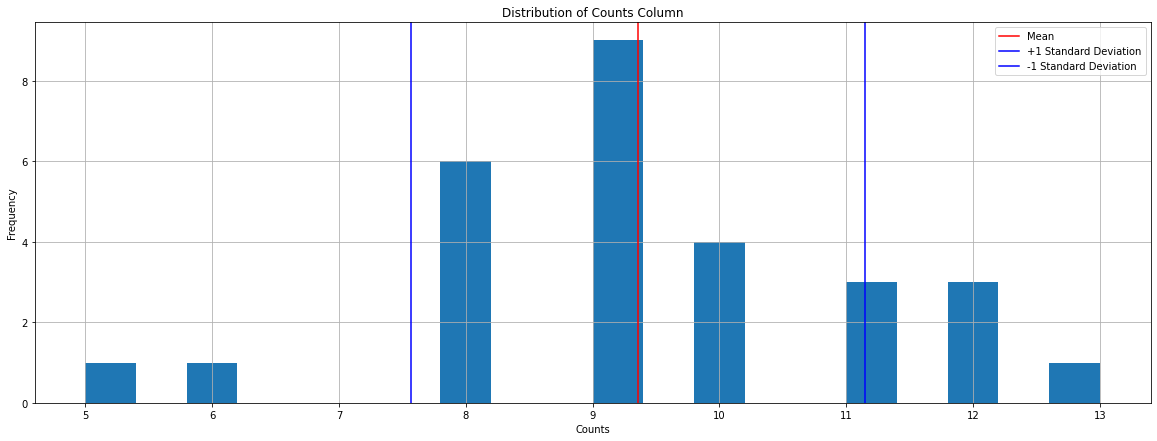

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 7))

import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean and standard deviation of the counts column
mean = counts['counts'].mean()
std = counts['counts'].std()

# Plot the histogram of the counts column
counts['counts'].hist(bins=20)

# Add vertical lines to indicate mean and standard deviation
plt.axvline(mean, color='red', label='Mean')
plt.axvline(mean + std, color='blue', label='+1 Standard Deviation')
plt.axvline(mean - std, color='blue', label='-1 Standard Deviation')

# Add title and labels
plt.title('Distribution of Counts Column')
plt.xlabel('Counts')
plt.ylabel('Frequency')
plt.legend()

# Show plot
plt.show()

In [ ]:
rides['pickup_day'] = rides['pickup_day'].fillna(0).astype(int)
rides['pickup_month'] = rides['pickup_month'].fillna(0).astype(int)

rides['pickup_day'] = rides['pickup_day'].astype(str)
rides['pickup_month'] = rides['pickup_month'].astype(str)

rides['id'] = rides['pickup_month'] + rides['pickup_day']

rides = rides.drop(['pickup_month','pickup_day'], axis=1)

In [ ]:
rides.head()

,space_type,billable_distance,run_name,rider.mediroutes_rider_id,pickup.event_location.zip,pickup.event_location.longitude,pickup.event_location.latitude,dropoff.event_location.zip,dropoff.event_location.longitude,dropoff.event_location.latitude,pickup_hour,pickup_minute,id
0,1.000000,0.020619,0.0,0.045455,0.300000,-0.996971,0.993242,0.03125,-0.997400,0.994884,0.000000,1.000000,12
1,0.333333,0.005055,0.0,0.257576,0.600000,-0.996493,0.993262,0.81250,-0.996241,0.993313,0.083333,0.333333,12
2,1.000000,0.007725,0.0,0.515152,0.600000,-0.996372,0.992653,0.81250,-0.996193,0.992977,0.166667,0.000000,12
3,0.333333,0.062177,0.0,0.272727,0.333333,-0.993221,0.985946,0.59375,-0.994925,0.990800,0.333333,0.000000,12
4,0.333333,0.013177,0.0,0.151515,0.466667,-0.995843,0.993297,0.81250,-0.996241,0.993314,0.416667,0.000000,12


In [ ]:
rides.shape

(262, 13)

In [ ]:
rides = rides.astype(str)

In [ ]:
rides.values[0].astype('float32')

array([ 1.        ,  0.02061856,  0.        ,  0.04545455,  0.3       ,
       -0.99697095,  0.9932419 ,  0.03125   , -0.9973999 ,  0.99488443,
        0.        ,  1.        , 12.        ], dtype=float32)

# DAY NUMBER WE ARE TRAINING - SET IT HERE FOR ALL BELOW CODE

In [ ]:
len(max(rides, key=len))

32

In [ ]:
day_of_rides = 0
sequence_len = 13

Put rides into buckets by date

In [ ]:
# Group the rows by the 'id' column
grouped = rides.groupby('id')

# Create a list to store the grouped arrays
day_buckets = []

# Loop through each group
for name, group in grouped:
    # Convert the group to a numpy array
    group_array = group.values.astype(np.float32)
    
    # Append the group array to the list of grouped arrays
    day_buckets.append(group_array)

# Set the display format of the numpy arrays
np.set_printoptions(precision=6, suppress=True)

# Sort the list of grouped arrays by the first column of each array
day_buckets.sort(key=lambda x: x[0][1])


In [ ]:
# Do this or when you shuffle below it will shuffle both for some fucking reason, and copy doesn't work.
day_buckets_y = [x.astype(str) for x in day_buckets[1:]]

In [ ]:
len(day_buckets_y[9])

12

In [ ]:
# Get a look at the run's unique day/schedule lengths for each day in the year.
unique_lengths = list(set(len(sub_array) for sub_array in day_buckets_y))

In [ ]:
unique_lengths

[5, 6, 8, 9, 10, 11, 12, 13]

In [ ]:
day_buckets_y[0]

array([['1.0', '0.020550499', '0.0', '0.045454547', '0.3', '-0.99697095',
        '0.9932419', '0.03125', '-0.9973999', '0.99488443', '0.0', '1.0',
        '110.0'],
       ['0.33333334', '0.019966312', '0.0', '0.21212122', '0.26666668',
        '-0.99644196', '0.9920201', '0.5625', '-0.9958683', '0.9912264',
        '0.083333336', '1.0', '110.0'],
       ['0.0', '0.050601106', '0.0', '0.10606061', '0.2', '-0.9980458',
        '0.9966702', '0.375', '-0.9967102', '0.9936471', '0.25', '1.0',
        '110.0'],
       ['1.0', '0.02990315', '0.0', '0.22727273', '0.8666667',
        '-0.99619335', '0.992977', '0.96875', '-0.99613476',
        '0.99532086', '0.41666666', '0.6666667', '110.0'],
       ['1.0', '0.012014573', '0.0', '0.43939394', '0.8666667',
        '-0.99619335', '0.992977', '0.71875', '-0.9958649', '0.99306273',
        '0.41666666', '0.6666667', '110.0'],
       ['1.0', '0.0021703742', '0.0', '0.3030303', '0.6', '-0.9964902',
        '0.99326324', '0.59375', '-0.99658185', '

In [ ]:
def shuffle_np_array(np_array_list):
    for i in range(len(np_array_list)):
        np.random.shuffle(np_array_list[i])
    return np_array_list

day_buckets_X = shuffle_np_array(day_buckets)[1:] # create a shuffled version for X below

In [ ]:
input = []
target = []
for array in day_buckets_X:
    new_array = np.delete(array, -1, axis=1)
    input.append(new_array.astype('float32'))

count = 0
for array in day_buckets_y:
    new_array = np.delete(array, -1, axis=1)
    target.append(new_array.astype('float32'))


# Load the model for the training loop

In [ ]:
# Set early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
# Create a TensorBoard callback
import datetime

logdir = "/content/drive/MyDrive/tensorboard_logs" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
def pad_array(arr):

    padding = np.zeros((1, 12))
    while arr.shape[0] < sequence_len:
        arr = np.concatenate((arr, padding), axis=0)
    return arr

def create_validation_set():
  random_validation_set = np.random.randint(0, len(day_buckets_X))

  if not random_validation_set == day_of_rides:
    print('random_validation_set: ', random_validation_set)
    print('day_of_rides: ', day_of_rides)
    X_val = input[-1].astype('float32')
    X_val = pad_array(X_val)

    y_val = target[-1].astype('float32')
    y_val = pad_array(y_val)

    return X_val, y_val
  else:
    # Recursively call the function until it lands on a random day of rides that doesn't match the training tensor.
    create_validation_set()

In this example, an attention mechanism is added to the decoder by creating an Attention layer, which takes in the decoder outputs and encoder outputs, and returns the attention-weighted representation of the decoder outputs. This attention-weighted representation is then passed through a dense layer to make the final predictions.

This is just one way to implement attention mechanism, there are other ways as well.

In [ ]:
# dummy = np.zeros((1,200,12))
# dummy.shape
# pred = model.predict([input_, dummy])

# pred[0][1]

In [ ]:

first_run = False

# TRAINING LOOP
start_at = 1
train_until = 30
for day_of_rides in range(start_at, train_until): # num days to be trained

  if not first_run:
    print(f'Training {day_of_rides} of {train_until}')
    model = keras.models.load_model('/content/drive/MyDrive/Colab_Models/RBSeq2Seq')

  # Pad the input
  input[day_of_rides] = pad_array(input[day_of_rides])
  target[day_of_rides] = pad_array(target[day_of_rides])

  # print(pad_array(input[day_of_rides]))

  # Truncate input to defined sequence length
  input[day_of_rides] = input[day_of_rides][:sequence_len]
  target[day_of_rides] = target[day_of_rides][:sequence_len]

  # Create Random Validation Set
  X_val, y_val = create_validation_set()

  # Create Input and Target Df's
  input_df = pd.DataFrame(input[day_of_rides], columns=[
  'input_space_type',
  'input_billable_distance',
  'input_run_name',
  'input_rider.mediroutes_rider_id',
  'input_pickup.event_location.zip',
  'input_pickup.event_location.longitude',
  'input_pickup.event_location.latitude',
  'input_dropoff.event_location.zip',
  'input_dropoff.event_location.longitude',
  'input_dropoff.event_location.latitude',
  'input_pickup_hour',
  'input_pickup_minute'
  ])

  target_df = pd.DataFrame(target[day_of_rides], columns=[
  'target_space_type',
  'target_billable_distance',
  'target_run_name',
  'target_rider.mediroutes_rider_id',
  'target_pickup.event_location.zip',
  'target_pickup.event_location.longitude',
  'target_pickup.event_location.latitude',
  'target_dropoff.event_location.zip',
  'target_dropoff.event_location.longitude',
  'target_dropoff.event_location.latitude',
  'target_pickup_hour',
  'target_pickup_minute'
  ])

  # Define the input and output shape
  input_shape = (sequence_len, 12)
  output_shape = (sequence_len, 12)

  # Set the input and target to the day of rides iteration
  input_orig = input[day_of_rides]
  target_orig = target[day_of_rides]

  input_ = input_orig.reshape(1, *input_orig.shape)
  target_ = target_orig.reshape(1, *target_orig.shape)
  X_val = X_val.reshape(1, *X_val.shape)
  y_val = y_val.reshape(1, *y_val.shape)

  print(input_.shape)
  print(input_.shape)
  print(X_val.shape)
  print(y_val.shape)


  # Define the model architecture
  inputs = keras.layers.Input(shape=(None, 12))
  encoder = keras.layers.GRU(128, return_state=True)
  encoder_outputs, state_h = encoder(inputs)
  encoder_states = [state_h]

  decoder = keras.layers.GRU(128, return_sequences=True)
  decoder_outputs = decoder(inputs, initial_state=encoder_states)

  outputs = keras.layers.Dense(12, activation='linear')(decoder_outputs)

  if first_run:
    model = keras.models.Model(inputs=inputs, outputs=outputs)
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.mse)
    print('Training first run.')
  
  # Train the model
  history = model.fit(input_, target_, epochs=400, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=2)
  print('Saving model.')
  model.save('/content/drive/MyDrive/Colab_Models/RBSeq2Seq')

Training 1 of 30
random_validation_set:  19
day_of_rides:  1
(1, 13, 12)
(1, 13, 12)
(1, 13, 12)
(1, 13, 12)
Epoch 1/400
1/1 - 7s - loss: 0.0580 - val_loss: 0.0686 - 7s/epoch - 7s/step
Epoch 2/400
1/1 - 0s - loss: 0.0557 - val_loss: 0.0674 - 50ms/epoch - 50ms/step
Epoch 3/400
1/1 - 0s - loss: 0.0536 - val_loss: 0.0663 - 52ms/epoch - 52ms/step
Epoch 4/400
1/1 - 0s - loss: 0.0517 - val_loss: 0.0655 - 45ms/epoch - 45ms/step
Epoch 5/400
1/1 - 0s - loss: 0.0501 - val_loss: 0.0649 - 48ms/epoch - 48ms/step
Epoch 6/400
1/1 - 0s - loss: 0.0488 - val_loss: 0.0644 - 49ms/epoch - 49ms/step
Epoch 7/400
1/1 - 0s - loss: 0.0476 - val_loss: 0.0641 - 47ms/epoch - 47ms/step
Epoch 8/400
1/1 - 0s - loss: 0.0467 - val_loss: 0.0639 - 49ms/epoch - 49ms/step
Epoch 9/400
1/1 - 0s - loss: 0.0459 - val_loss: 0.0637 - 52ms/epoch - 52ms/step
Epoch 10/400
1/1 - 0s - loss: 0.0452 - val_loss: 0.0636 - 59ms/epoch - 59ms/step
Epoch 11/400
1/1 - 0s - loss: 0.0446 - val_loss: 0.0635 - 66ms/epoch - 66ms/step
Epoch 12/400


Training 2 of 30
random_validation_set:  13
day_of_rides:  2
(1, 13, 12)
(1, 13, 12)
(1, 13, 12)
(1, 13, 12)
Epoch 1/400
1/1 - 6s - loss: 0.0254 - val_loss: 0.0447 - 6s/epoch - 6s/step
Epoch 2/400
1/1 - 0s - loss: 0.0244 - val_loss: 0.0437 - 51ms/epoch - 51ms/step
Epoch 3/400
1/1 - 0s - loss: 0.0236 - val_loss: 0.0431 - 54ms/epoch - 54ms/step
Epoch 4/400
1/1 - 0s - loss: 0.0230 - val_loss: 0.0426 - 48ms/epoch - 48ms/step
Epoch 5/400
1/1 - 0s - loss: 0.0226 - val_loss: 0.0424 - 61ms/epoch - 61ms/step
Epoch 6/400
1/1 - 0s - loss: 0.0222 - val_loss: 0.0423 - 74ms/epoch - 74ms/step
Epoch 7/400
1/1 - 0s - loss: 0.0220 - val_loss: 0.0423 - 50ms/epoch - 50ms/step
Epoch 8/400
1/1 - 0s - loss: 0.0217 - val_loss: 0.0424 - 57ms/epoch - 57ms/step
Epoch 9/400
1/1 - 0s - loss: 0.0216 - val_loss: 0.0424 - 51ms/epoch - 51ms/step
Epoch 10/400
1/1 - 0s - loss: 0.0214 - val_loss: 0.0425 - 51ms/epoch - 51ms/step
Epoch 11/400
1/1 - 0s - loss: 0.0213 - val_loss: 0.0425 - 53ms/epoch - 53ms/step
Saving model.

KeyboardInterrupt: ignored

In [ ]:
pred = model.predict(input_)

1/1 [==============================] - 1s 575ms/step


In [ ]:
pred[0][0]

array([ 0.000132,  0.050394,  0.000134,  0.105545,  0.199388, -0.998259,
        0.996217,  0.374753, -0.996707,  0.993591,  0.250021,  0.999017],
      dtype=float32)

In [ ]:
target_[0][0]

array([ 0.      ,  0.050601,  0.      ,  0.106061,  0.2     , -0.998046,
        0.99667 ,  0.375   , -0.99671 ,  0.993647,  0.25    ,  1.      ])

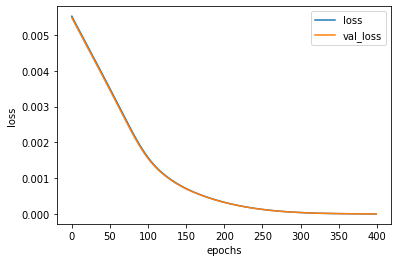

In [ ]:
# Plot history (also known as a loss curve)
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs");

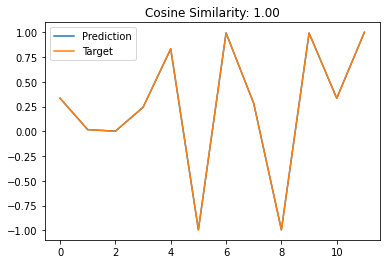

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

def plot_vectors_cosine_similarity(vector1, vector2):
    similarity = cosine_similarity([vector1], [vector2])[0][0]
    fig, ax = plt.subplots()
    ax.plot(vector1, label='Prediction')
    ax.plot(vector2, label='Target')
    ax.set_title('Cosine Similarity: {:.2f}'.format(similarity))
    ax.legend()
    plt.show()
index = 1
plot_vectors_cosine_similarity(pred[0][index], target_[0][index])

In [ ]:
def comparison_ordering(master, slave):
  """ Compares and orders the inputs by the preds """

  max_finder = pd.DataFrame(columns=["pred", "original_input", "cos_similarity"])
  ordered_rides = pd.DataFrame(columns = [
    'space_type',
    'billable_distance',
    'run_name',
    'rider.mediroutes_rider_id',
    'pickup.event_location.zip',
    'pickup.event_location.longitude',
    'pickup.event_location.latitude',
    'dropoff.event_location.zip',
    'dropoff.event_location.longitude',
    'dropoff.event_location.latitude',
    'pickup_hour',
    'pickup_minute',
    'prediction_highest_scores',
    'similarity_high_score'
  ])

  for i in master: # order the j vector by the master
    for j in slave:
      cos_similarity = cosine_similarity(i.reshape(1, -1), j.reshape(1, -1))

      # Add mapping to max finder
      row = {"pred": i, "original_input": j, "cos_similarity": cos_similarity}
      max_finder = max_finder.append(row, ignore_index=True)

    # Find the winner
    max_row_index = np.argmax(max_finder['cos_similarity'])
    most_similar = max_finder.loc[max_row_index]

    # Get prediction info - just a check to see if max_row_index is returning the best value every time.
    max_finder.sort_values(by='cos_similarity', ascending=False, inplace=True)
    scores = max_finder['cos_similarity'][:3]
    scores = [round(x[0][0],4) for x in scores]

    highest_score = np.amax(scores)
    prediction_info = [np.sort(scores), highest_score]

    # Add most similar ride to ordered rides in order of predictions against the target
    row = {'space_type' : most_similar[1][0],
    'billable_distance' : most_similar[1][1],
    'run_name' : most_similar[1][2],
    'rider.mediroutes_rider_id' : most_similar[1][3],
    'pickup.event_location.zip' : most_similar[1][4],
    'pickup.event_location.longitude' : most_similar[1][5],
    'pickup.event_location.latitude' : most_similar[1][6],
    'dropoff.event_location.zip' : most_similar[1][7],
    'dropoff.event_location.longitude' : most_similar[1][8],
    'dropoff.event_location.latitude' : most_similar[1][9],
    'pickup_hour' : most_similar[1][10],
    'pickup_minute' : most_similar[1][11],
    'prediction_highest_scores' : prediction_info[:-1],
    'similarity_high_score' : prediction_info[1]
    }
    
    ordered_rides = ordered_rides.append(row, ignore_index=True)

    # Reset max finder so it starts empty for the next iteration
    max_finder = pd.DataFrame(columns=["pred", "original_input", "cos_similarity"])
    scores = []
  return ordered_rides

ordered_rides = comparison_ordering(pred[0], input_[0])

In [ ]:
ordered_rides.iloc[:10,:]

,space_type,billable_distance,run_name,rider.mediroutes_rider_id,pickup.event_location.zip,pickup.event_location.longitude,pickup.event_location.latitude,dropoff.event_location.zip,dropoff.event_location.longitude,dropoff.event_location.latitude,pickup_hour,pickup_minute,prediction_highest_scores,similarity_high_score
0,0.000000,0.050601,0.0,0.106061,0.200000,-0.998046,0.996670,0.37500,-0.996710,0.993647,0.250000,1.000000,"[[0.8883, 0.9535, 1.0]]",1.0
1,0.333333,0.016161,0.0,0.242424,0.833333,-0.996126,0.992759,0.28125,-0.996352,0.991501,0.333333,1.000000,"[[0.9526, 0.9536, 1.0]]",1.0
2,1.000000,0.003702,0.0,0.530303,0.900000,-0.996556,0.993023,0.84375,-0.996582,0.993274,0.416667,0.333333,"[[0.9864, 0.9903, 1.0]]",1.0
3,1.000000,0.012015,0.0,0.439394,0.866667,-0.996193,0.992977,0.71875,-0.995865,0.993063,0.416667,0.666667,"[[0.9856, 0.9904, 1.0]]",1.0
4,1.000000,0.002170,0.0,0.303030,0.600000,-0.996490,0.993263,0.59375,-0.996582,0.993275,0.500000,0.333333,"[[0.9865, 0.9893, 1.0]]",1.0
5,1.000000,0.013620,0.0,0.681818,0.533333,-0.995742,0.993810,0.62500,-0.995342,0.993172,0.583333,0.000000,"[[0.9939, 0.9969, 1.0]]",1.0
6,1.000000,0.013620,0.0,0.393939,0.533333,-0.995742,0.993810,0.62500,-0.995342,0.993172,0.583333,0.000000,"[[0.9892, 0.9937, 1.0]]",1.0
7,1.000000,0.013107,0.0,0.818182,0.533333,-0.995785,0.993697,0.50000,-0.995512,0.994284,0.666667,0.000000,"[[0.9905, 0.9969, 1.0]]",1.0
8,1.000000,0.014106,0.0,0.500000,0.666667,-0.995212,0.992815,0.50000,-0.995539,0.993897,0.666667,1.000000,"[[0.9654, 0.9819, 1.0]]",1.0
9,1.000000,0.014342,0.0,0.757576,0.566667,-0.995512,0.994284,0.65625,-0.995569,0.993345,0.750000,0.333333,"[[0.9895, 0.9898, 1.0]]",1.0


In [ ]:
target_df.iloc[:10,:]

,target_space_type,target_billable_distance,target_run_name,target_rider.mediroutes_rider_id,target_pickup.event_location.zip,target_pickup.event_location.longitude,target_pickup.event_location.latitude,target_dropoff.event_location.zip,target_dropoff.event_location.longitude,target_dropoff.event_location.latitude,target_pickup_hour,target_pickup_minute
0,0.000000,0.050601,0.0,0.106061,0.200000,-0.998046,0.996670,0.37500,-0.996710,0.993647,0.250000,1.000000
1,0.333333,0.016161,0.0,0.242424,0.833333,-0.996126,0.992759,0.28125,-0.996352,0.991501,0.333333,1.000000
2,1.000000,0.003702,0.0,0.530303,0.900000,-0.996556,0.993023,0.84375,-0.996582,0.993274,0.416667,0.333333
3,1.000000,0.012015,0.0,0.439394,0.866667,-0.996193,0.992977,0.71875,-0.995865,0.993063,0.416667,0.666667
4,1.000000,0.002170,0.0,0.303030,0.600000,-0.996490,0.993263,0.59375,-0.996582,0.993275,0.500000,0.333333
5,1.000000,0.013620,0.0,0.681818,0.533333,-0.995742,0.993810,0.62500,-0.995342,0.993172,0.583333,0.000000
6,1.000000,0.013620,0.0,0.393939,0.533333,-0.995742,0.993810,0.62500,-0.995342,0.993172,0.583333,0.000000
7,1.000000,0.013107,0.0,0.818182,0.533333,-0.995785,0.993697,0.50000,-0.995512,0.994284,0.666667,0.000000
8,1.000000,0.014106,0.0,0.500000,0.666667,-0.995212,0.992815,0.50000,-0.995539,0.993897,0.666667,1.000000
9,1.000000,0.014342,0.0,0.757576,0.566667,-0.995512,0.994284,0.65625,-0.995569,0.993345,0.750000,0.333333


In [ ]:
target_df = pd.DataFrame(target[0], columns=[
  'space_type',
  'billable_distance',
  'run_name',
  'rider.mediroutes_rider_id',
  'pickup.event_location.zip',
  'pickup.event_location.longitude',
  'pickup.event_location.latitude',
  'dropoff.event_location.zip',
  'dropoff.event_location.longitude',
  'dropoff.event_location.latitude',
  'pickup_hour',
  'pickup_minute'
])

In [ ]:
target_df.head(10)